In [18]:
#!pip install missingno
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import missingno as msno
from sklearn.tree import DecisionTreeClassifier


In [32]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test_fix1.csv")

In [57]:
y_test=pd.read_csv("sampleSubmission.csv")
y_test['Reached.on.Time_Y.N'] = 1
y_test.to_csv('y_test.csv', index=False)


In [58]:
y_test=pd.read_csv("y_test.csv")
y_test


,ID,Reached.on.Time_Y.N
0,7000,1
1,7001,1
2,7002,1
3,7003,1
4,7004,1
...,...,...
3995,10995,1
3996,10996,1
3997,10997,1
3998,10998,1


In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999 entries, 0 to 6998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   6999 non-null   int64  
 1   Warehouse_block      6999 non-null   object 
 2   Mode_of_Shipment     6999 non-null   object 
 3   Customer_care_calls  5423 non-null   float64
 4   Customer_rating      6999 non-null   int64  
 5   Cost_of_the_Product  6999 non-null   int64  
 6   Prior_purchases      6049 non-null   float64
 7   Product_importance   6999 non-null   object 
 8   Gender               6999 non-null   object 
 9   Discount_offered     3468 non-null   float64
 10  Weight_in_gms        6999 non-null   object 
 11  Reached.on.Time_Y.N  6999 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 656.3+ KB


In [30]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      4000 non-null   object 
 1   Mode_of_Shipment     4000 non-null   object 
 2   Customer_care_calls  3144 non-null   float64
 3   Customer_rating      4000 non-null   int64  
 4   Cost_of_the_Product  4000 non-null   int64  
 5   Prior_purchases      3633 non-null   float64
 6   Product_importance   4000 non-null   object 
 7   Discount_offered     2085 non-null   float64
 8   Weight_in_gms        4000 non-null   object 
dtypes: float64(3), int64(2), object(4)
memory usage: 281.4+ KB


# Train 결측치 수정

# Customer_care_calls 0 으로 채움

In [310]:
# Customer_care_calls 0 으로 채움
train['Customer_care_calls'].fillna(0, inplace=True)  
test['Customer_care_calls'].fillna(0, inplace=True)  

# Discount_offered 결측치 채움

In [311]:
# 결측치를 75% 값(10)으로, 25% 값(7)으로 채우기

# 75% 백분위수 계산
q75 = train['Discount_offered'].quantile(0.75)
q75_test = test['Discount_offered'].quantile(0.75)

# 25% 백분위수 계산
q25 = train['Discount_offered'].quantile(0.25)
q25_test = test['Discount_offered'].quantile(0.25)

# 75% 백분위수 값으로 채울 행의 개수 계산 (전체 데이터의 75%)
num_rows_7 = int(0.75 * len(train))
num_rows_7_test = int(0.75 * len(test))

# 75% 백분위수 행을 식별하기 위한 마스크 생성
mask_7 = np.arange(len(train)) < num_rows_7
mask_7_test = np.arange(len(test)) < num_rows_7_test

# 75% 백분위수에 해당하는 행은 10으로 채우기
train.loc[mask_7, 'Discount_offered'] = 10
test.loc[mask_7_test, 'Discount_offered'] = 10

# 나머지 25% 백분위수에 해당하는 행은 7로 채우기
train.loc[~mask_7, 'Discount_offered'] = 7
test.loc[~mask_7_test, 'Discount_offered'] = 7

# Prior_purchases 결측치 채움 - 최빈값

In [312]:
train['Prior_purchases'].fillna(train['Prior_purchases'].mode()[0], inplace=True)  

test['Prior_purchases'].fillna(test['Prior_purchases'].mode()[0], inplace=True)  

# Mode_of_Shipment - 100% 정답이기 때문에 ship으로 떄려박자

In [313]:
train['Mode_of_Shipment'].replace('?', 'Ship', inplace=True)
test['Mode_of_Shipment'].replace('?', 'Ship', inplace=True)

# Product_importance ? 값 대체 반 반 안되서  medium으로

In [314]:
train['Product_importance'].replace('?', 'medium', inplace=True)
test['Product_importance'].replace('?', 'medium', inplace=True)

# Weight_in_gms ? 3000 으로 대체(09_12test참고)
# 결측치도 존재
- train은 2000~4000대 까지 값이 있으나  test는 존재하지않음
- 평균값 4189 넣어보고 - 65 
- 3000대 값 넣어보기 - 65 비슷

- 09_13 2천~ 4천 사이의 값을 넣어 보겟음

In [315]:
# train ? = 446

# test ? = 252

# 이상치 해결
train['Weight_in_gms'].replace('?', 3000, inplace=True)
# 결측치 해결
train['Weight_in_gms'].fillna(train['Weight_in_gms'].mode()[0], inplace=True)  
# 타입 변경
train['Weight_in_gms'] = train['Weight_in_gms'].astype('int64')

# 이상치 해결
#       test['Weight_in_gms'].replace('?', 3000, inplace=True)

# 2000~ 4000 사이 랜덤 수 넣기
test['Weight_in_gms'] = test['Weight_in_gms'].replace('?', np.random.randint(2000, 4001))

# 결측치 해결
test['Weight_in_gms'].fillna(test['Weight_in_gms'].mode()[0], inplace=True)  
# 타입 변경
test['Weight_in_gms'] = test['Weight_in_gms'].astype('int64')
# 




In [316]:
X_train.corr()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium
Customer_care_calls,1.000000,0.009423,0.144350,-0.055720,-0.090415,-0.061375,0.013443,0.011019,-0.019065,0.030049,-0.034266,-0.011297
Customer_rating,0.009423,1.000000,0.006108,-0.011650,0.012086,0.001127,-0.000894,-0.005619,0.005105,-0.003362,0.006696,-0.000318
Cost_of_the_Product,0.144350,0.006108,1.000000,-0.096344,-0.118035,-0.068100,-0.017730,0.020011,-0.001985,0.041745,-0.033712,-0.023373
Discount_offered,-0.055720,-0.011650,-0.096344,1.000000,-0.246152,0.276998,-0.003290,0.003469,-0.000177,-0.011970,0.030130,-0.004609
Weight_in_gms,-0.090415,0.012086,-0.118035,-0.246152,1.000000,-0.254428,-0.003449,-0.014444,0.014015,-0.081980,0.074139,0.041515
Reached.on.Time_Y.N,-0.061375,0.001127,-0.068100,0.276998,-0.254428,1.000000,0.005365,0.003348,-0.006785,-0.012308,0.024041,-0.000904
Mode_of_Shipment_Flight,0.013443,-0.000894,-0.017730,-0.003290,-0.003449,0.005365,1.000000,-0.178060,-0.634623,-0.010488,0.009820,0.005126
Mode_of_Shipment_Road,0.011019,-0.005619,0.020011,0.003469,-0.014444,0.003348,-0.178060,1.000000,-0.647472,-0.001782,0.015527,-0.006789
Mode_of_Shipment_Ship,-0.019065,0.005105,-0.001985,-0.000177,0.014015,-0.006785,-0.634623,-0.647472,1.000000,0.009523,-0.019800,0.001362
Product_importance_high,0.030049,-0.003362,0.041745,-0.011970,-0.081980,-0.012308,-0.010488,-0.001782,0.009523,1.000000,-0.285978,-0.848206


In [317]:
corr_matrix = X_train.corr()
reordered_columns = ['Reached.on.Time_Y.N'] + [col for col in corr_matrix.columns if col != 'Reached.on.Time_Y.N']
corr_matrix = corr_matrix[reordered_columns]
corr_matrix

,Reached.on.Time_Y.N,Customer_care_calls,Customer_rating,Cost_of_the_Product,Discount_offered,Weight_in_gms,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium
Customer_care_calls,-0.061375,1.000000,0.009423,0.144350,-0.055720,-0.090415,0.013443,0.011019,-0.019065,0.030049,-0.034266,-0.011297
Customer_rating,0.001127,0.009423,1.000000,0.006108,-0.011650,0.012086,-0.000894,-0.005619,0.005105,-0.003362,0.006696,-0.000318
Cost_of_the_Product,-0.068100,0.144350,0.006108,1.000000,-0.096344,-0.118035,-0.017730,0.020011,-0.001985,0.041745,-0.033712,-0.023373
Discount_offered,0.276998,-0.055720,-0.011650,-0.096344,1.000000,-0.246152,-0.003290,0.003469,-0.000177,-0.011970,0.030130,-0.004609
Weight_in_gms,-0.254428,-0.090415,0.012086,-0.118035,-0.246152,1.000000,-0.003449,-0.014444,0.014015,-0.081980,0.074139,0.041515
Reached.on.Time_Y.N,1.000000,-0.061375,0.001127,-0.068100,0.276998,-0.254428,0.005365,0.003348,-0.006785,-0.012308,0.024041,-0.000904
Mode_of_Shipment_Flight,0.005365,0.013443,-0.000894,-0.017730,-0.003290,-0.003449,1.000000,-0.178060,-0.634623,-0.010488,0.009820,0.005126
Mode_of_Shipment_Road,0.003348,0.011019,-0.005619,0.020011,0.003469,-0.014444,-0.178060,1.000000,-0.647472,-0.001782,0.015527,-0.006789
Mode_of_Shipment_Ship,-0.006785,-0.019065,0.005105,-0.001985,-0.000177,0.014015,-0.634623,-0.647472,1.000000,0.009523,-0.019800,0.001362
Product_importance_high,-0.012308,0.030049,-0.003362,0.041745,-0.011970,-0.081980,-0.010488,-0.001782,0.009523,1.000000,-0.285978,-0.848206


# 원핫 인코딩

In [318]:
# 원핫 인코딩
X_train = pd.get_dummies(train)
X_test = pd.get_dummies(test)

In [319]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999 entries, 0 to 6998
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Customer_care_calls        6999 non-null   float64
 1   Customer_rating            6999 non-null   int64  
 2   Cost_of_the_Product        6999 non-null   int64  
 3   Prior_purchases            6999 non-null   float64
 4   Discount_offered           6999 non-null   float64
 5   Weight_in_gms              6999 non-null   int64  
 6   Reached.on.Time_Y.N        6999 non-null   int64  
 7   Warehouse_block_A          6999 non-null   uint8  
 8   Warehouse_block_B          6999 non-null   uint8  
 9   Warehouse_block_C          6999 non-null   uint8  
 10  Warehouse_block_D          6999 non-null   uint8  
 11  Warehouse_block_F          6999 non-null   uint8  
 12  Mode_of_Shipment_Flight    6999 non-null   uint8  
 13  Mode_of_Shipment_Road      6999 non-null   uint8

In [320]:
X_train.describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium
count,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000
mean,3.141592,2.996285,210.055008,3.498071,11.619803,3510.879840,0.594656,0.167738,0.166024,0.169167,0.166881,0.330190,0.148593,0.153736,0.697671,0.477925,0.082012,0.440063
std,1.964630,1.410161,48.220091,1.436854,11.428752,1680.168612,0.490993,0.373660,0.372129,0.374926,0.372896,0.470315,0.355712,0.360722,0.459300,0.499548,0.274402,0.496430
min,0.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,169.000000,3.000000,7.000000,1674.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,3.000000,214.000000,3.000000,10.000000,4064.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,5.000000,4.000000,251.000000,4.000000,10.000000,5005.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [321]:
X_test.describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium
count,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.187250,2.98125,210.420250,3.515250,11.710750,3597.761000,0.164750,0.167750,0.162250,0.166500,0.338750,0.149750,0.154500,0.695750,0.090250,0.468250,0.441500
std,1.956053,1.41912,47.755542,1.460582,11.548222,1593.715242,0.371001,0.373691,0.368726,0.372575,0.473344,0.356871,0.361473,0.460147,0.286575,0.499053,0.496628
min,0.000000,1.00000,96.000000,2.000000,1.000000,1003.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.00000,170.000000,3.000000,7.000000,1876.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,3.00000,214.000000,3.000000,10.000000,4045.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,5.000000,4.00000,251.000000,4.000000,10.000000,4987.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,7.000000,5.00000,310.000000,10.000000,65.000000,7684.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 테스트 완료됨 

In [275]:
#X_train.to_csv('train_fix_09_12.csv', index=False)
#X_test.to_csv('test_fix_09_12.csv', index=False)

In [284]:
#11/24
#X_train.to_csv('train_fix_09_12_2.csv', index=False)
#X_test.to_csv('test_fix_09_12_2.csv', index=False)

In [328]:
#11/35
X_train.to_csv('train_fix_09_12_3.csv', index=False)
X_test.to_csv('test_fix_09_12_3.csv', index=False)

In [322]:
# 0912_2,3=  레이팅 날림
X_train = X_train.drop('Customer_rating', axis=1) 
X_test = X_test.drop('Customer_rating', axis=1) 


In [323]:
# Product_importance_medium 날림
X_train = X_train.drop('Product_importance_medium', axis=1) 
X_test = X_test.drop('Product_importance_medium', axis=1) 


In [324]:
# Mode_of_Shipment_Road 날림
X_train = X_train.drop('Mode_of_Shipment_Road', axis=1) 
X_test = X_test.drop('Mode_of_Shipment_Road', axis=1) 


In [325]:
# Mode_of_Shipment_Ship 날림
X_train = X_train.drop('Mode_of_Shipment_Ship', axis=1) 
X_test = X_test.drop('Mode_of_Shipment_Ship', axis=1) 
# Mode_of_Shipment_Flight 날림
X_train = X_train.drop('Mode_of_Shipment_Flight', axis=1) 
X_test = X_test.drop('Mode_of_Shipment_Flight', axis=1) 
# Product_importance_high 날림
X_train = X_train.drop('Product_importance_high', axis=1) 
X_test = X_test.drop('Product_importance_high', axis=1) 
# Customer_care_calls 날림
X_train = X_train.drop('Customer_care_calls', axis=1) 
X_test = X_test.drop('Customer_care_calls', axis=1) 
# Prior_purchases 날림
X_train = X_train.drop('Prior_purchases', axis=1) 
X_test = X_test.drop('Prior_purchases', axis=1)


In [326]:
# Warehouse_block_A 날림
X_train = X_train.drop('Warehouse_block_A', axis=1) 
X_test = X_test.drop('Warehouse_block_A', axis=1)
# Warehouse_block_B 날림
X_train = X_train.drop('Warehouse_block_B', axis=1) 
X_test = X_test.drop('Warehouse_block_B', axis=1)
# Warehouse_block_C 날림
X_train = X_train.drop('Warehouse_block_C', axis=1) 
X_test = X_test.drop('Warehouse_block_C', axis=1)
# Warehouse_block_D 날림
X_train = X_train.drop('Warehouse_block_D', axis=1) 
X_test = X_test.drop('Warehouse_block_D', axis=1)
# Warehouse_block_F 날림
X_train = X_train.drop('Warehouse_block_F', axis=1) 
X_test = X_test.drop('Warehouse_block_F', axis=1)


In [327]:
# Prior_purchases 날림


In [9]:
test=pd.read_csv('test.csv')

In [12]:
test['Discount_offered'].describe

<bound method NDFrame.describe of 0       NaN
1       NaN
2       7.0
3       NaN
4       5.0
       ... 
3995    NaN
3996    NaN
3997    7.0
3998    7.0
3999    4.0
Name: Discount_offered, Length: 4000, dtype: float64>

In [13]:
1915/4000

0.47875

In [31]:
(test['Weight_in_gms'] == '?').sum()

252

In [24]:
len(train[(train['Weight_in_gms'] == '?') & (train['Reached.on.Time_Y.N'] == 1)])


0

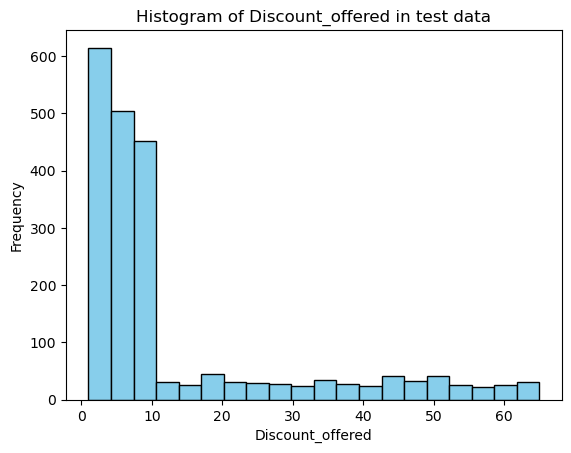

In [10]:

import matplotlib.pyplot as plt

# 'test' 데이터프레임의 'Discount_offered' 열을 히스토그램으로 시각화
plt.hist(test['Discount_offered'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Discount_offered')
plt.ylabel('Frequency')
plt.title('Histogram of Discount_offered in test data')
plt.show()
